In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv('data/covid_19.csv')
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise

print(df.head())

            country      continent  population         day  \
0      Saint-Helena         Africa      6115.0  2024-06-30   
1  Falkland-Islands  South-America      3539.0  2024-06-30   
2        Montserrat  North-America      4965.0  2024-06-30   
3  Diamond-Princess            NaN         NaN  2024-06-30   
4      Vatican-City         Europe       799.0  2024-06-30   

                        time  Cases  Recovered  Deaths    Tests  
0  2024-06-30T16:15:16+00:00   2166        2.0     NaN      NaN  
1  2024-06-30T16:15:16+00:00   1930     1930.0     NaN   8632.0  
2  2024-06-30T16:15:16+00:00   1403     1376.0     8.0  17762.0  
3  2024-06-30T16:15:16+00:00    712      699.0    13.0      NaN  
4  2024-06-30T16:15:16+00:00     29       29.0     NaN      NaN  


The script preprocesses the data by handling missing values and creating new columns.

Checking for Missing Values: Identifies the number of missing values in each column.
Ensuring 'day' Column is in Datetime Format: Converts the 'day' column to datetime format.
Adding 'Active_Cases' Column: Calculates active cases as Cases - Recovered - Deaths.

In [3]:
# Check for missing values
missing_values = df.isnull().sum()

# Ensure the 'day' column is in datetime format
df['day'] = pd.to_datetime(df['day'])

# Add a column for active cases
df['Active_Cases'] = df['Cases'] - df['Recovered'] - df['Deaths']

# Display the updated DataFrame and missing values
df.head(), missing_values

(            country      continent  population        day  \
 0      Saint-Helena         Africa      6115.0 2024-06-30   
 1  Falkland-Islands  South-America      3539.0 2024-06-30   
 2        Montserrat  North-America      4965.0 2024-06-30   
 3  Diamond-Princess            NaN         NaN 2024-06-30   
 4      Vatican-City         Europe       799.0 2024-06-30   
 
                         time  Cases  Recovered  Deaths    Tests  Active_Cases  
 0  2024-06-30T16:15:16+00:00   2166        2.0     NaN      NaN           NaN  
 1  2024-06-30T16:15:16+00:00   1930     1930.0     NaN   8632.0           NaN  
 2  2024-06-30T16:15:16+00:00   1403     1376.0     8.0  17762.0          19.0  
 3  2024-06-30T16:15:16+00:00    712      699.0    13.0      NaN           0.0  
 4  2024-06-30T16:15:16+00:00     29       29.0     NaN      NaN           NaN  ,
 country        0
 continent      2
 population     9
 day            0
 time           0
 Cases          0
 Recovered     48
 Deaths      

Continent and Population Mapping: Maps countries to their continents and population if missing.
Filling Missing Values: Fills missing 'Recovered', 'Deaths', and 'Tests' with zeros and recalculates 'Active_Cases'.

In [4]:
# Define the continent and population mapping
continent_population_map = {
    'Saint-Helena': ('Africa', 6115),
    'Falkland-Islands': ('South-America', 3539),
    'Montserrat': ('North-America', 4965),
    'Diamond-Princess': (np.nan, np.nan),
    'Vatican-City': ('Europe', 799),
}

# Apply mappings with error handling
df['continent'] = df.apply(lambda row: continent_population_map[row['country']][0] 
                            if pd.isna(row['continent']) and row['country'] in continent_population_map 
                            else row['continent'], axis=1)

df['population'] = df.apply(lambda row: continent_population_map[row['country']][1] 
                            if pd.isna(row['population']) and row['country'] in continent_population_map 
                            else row['population'], axis=1)

# Fill missing 'Recovered', 'Deaths', and 'Tests' with zeros
df['Recovered'].fillna(0, inplace=True)
df['Deaths'].fillna(0, inplace=True)
df['Tests'].fillna(0, inplace=True)

# Recalculate 'Active_Cases' after filling missing values
df['Active_Cases'] = df['Cases'] - df['Recovered'] - df['Deaths']

# Verify changes
missing_values_after = df.isnull().sum()
print("Missing values after processing:\n", missing_values_after)

# Display the first few rows of the updated DataFrame
print(df.head())

Missing values after processing:
 country         0
continent       2
population      9
day             0
time            0
Cases           0
Recovered       0
Deaths          0
Tests           0
Active_Cases    0
dtype: int64
            country      continent  population        day  \
0      Saint-Helena         Africa      6115.0 2024-06-30   
1  Falkland-Islands  South-America      3539.0 2024-06-30   
2        Montserrat  North-America      4965.0 2024-06-30   
3  Diamond-Princess            NaN         NaN 2024-06-30   
4      Vatican-City         Europe       799.0 2024-06-30   

                        time  Cases  Recovered  Deaths    Tests  Active_Cases  
0  2024-06-30T16:15:16+00:00   2166        2.0     0.0      0.0        2164.0  
1  2024-06-30T16:15:16+00:00   1930     1930.0     0.0   8632.0           0.0  
2  2024-06-30T16:15:16+00:00   1403     1376.0     8.0  17762.0          19.0  
3  2024-06-30T16:15:16+00:00    712      699.0    13.0      0.0           0.0  
4  202

In [5]:
# Identify unique countries with missing 'continent' or 'population'
missing_countries = df[df['continent'].isnull() | df['population'].isnull()]['country'].unique()
missing_countries

array(['Diamond-Princess', 'MS-Zaandam', 'North-America', 'Asia',
       'Europe', 'South-America', 'Oceania', 'Africa', 'All'],
      dtype=object)

Descriptive Statistics: Calculates and displays descriptive statistics for 'Cases', 'Recovered', 'Deaths', 'Active_Cases', and 'Tests'.

Histograms: Plots histograms for the distribution of these columns.

Scatter Plot: Creates a scatter plot of 'Cases' vs. 'Tests' colored by continent.

In [6]:
# Calculate descriptive statistics for the relevant columns
descriptive_stats = df[['Cases', 'Recovered', 'Deaths', 'Active_Cases', 'Tests']].describe()

# Display the descriptive statistics
descriptive_stats

,Cases,Recovered,Deaths,Active_Cases,Tests
count,2.380000e+02,2.380000e+02,2.380000e+02,2.380000e+02,2.380000e+02
mean,8.883449e+06,8.032801e+06,8.836987e+04,7.622787e+05,2.952313e+07
std,5.193031e+07,4.977610e+07,5.110324e+05,4.180256e+06,1.138312e+08
min,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.741875e+04,2.717500e+03,1.902500e+02,7.325000e+01,1.840850e+05
50%,2.320425e+05,6.530850e+04,2.267000e+03,1.558500e+03,1.551728e+06
75%,1.565481e+06,1.238110e+06,1.707325e+04,3.707650e+04,1.152990e+07
max,7.047539e+08,6.756198e+08,7.010681e+06,4.450182e+07,1.186852e+09


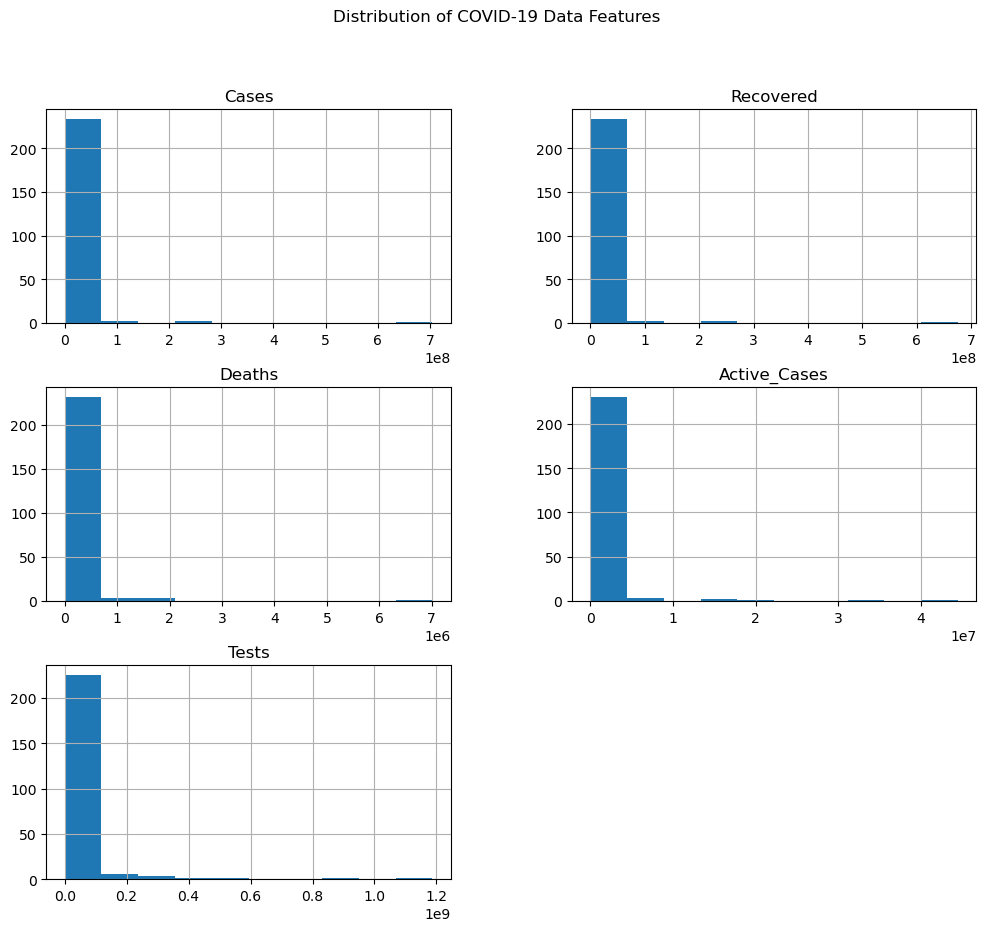

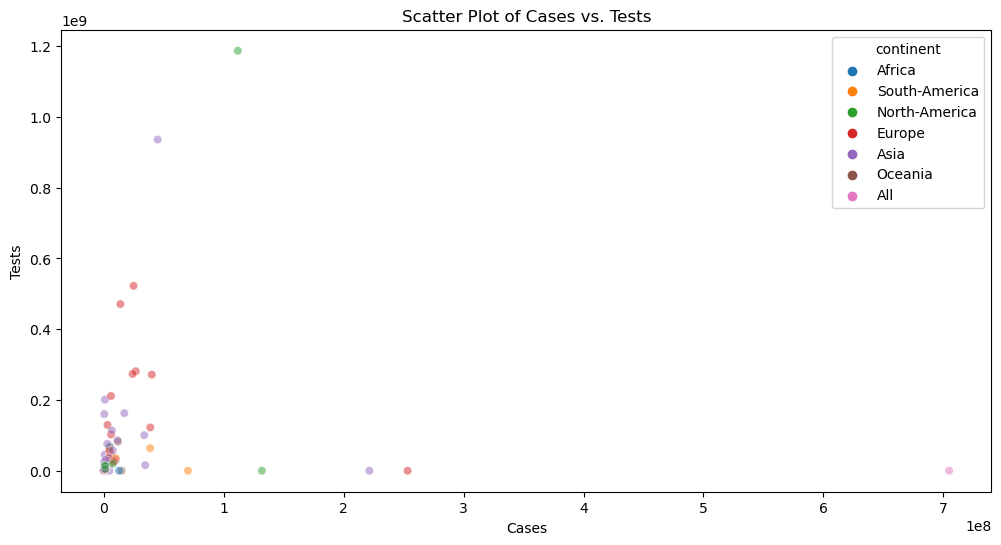

In [7]:
# Histograms
df[['Cases', 'Recovered', 'Deaths', 'Active_Cases', 'Tests']].hist(figsize=(12, 10))
plt.suptitle('Distribution of COVID-19 Data Features')
plt.show()

# Scatter plots
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Cases', y='Tests', hue='continent', alpha=0.5)
plt.title('Scatter Plot of Cases vs. Tests')
plt.show()

Loads latitude and longitude data and merges it with the COVID-19 data.
Then, an interactive map is created using Folium, adding markers for each country based on active cases.

In [8]:
try:
    latlong_data = pd.read_csv('data/world_country_and_usa_states_latitude_and_longitude_values.csv')
    merged_data = pd.merge(df, latlong_data[['country', 'latitude', 'longitude']], left_on='country', right_on='country', how='left')
    merged_data = merged_data.dropna(subset=['latitude', 'longitude'])
except KeyError as e:
    print(f"Error: Missing expected columns - {e}")
    raise
except Exception as e:
    print(f"Error: {e}")
    raise

m = folium.Map(location=[0, 0], zoom_start=2)

for index, row in merged_data.iterrows():
    # Customize marker icon based on climate-related data from the year 2020
    metric = row['Active_Cases']
    color = 'green'
    if metric > 20000:
        color = 'red'
    elif metric > 1000:
        color = 'orange'
    
    # Add marker with custom icon and tooltip
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=row['country'],
        icon=folium.Icon(color=color)
    ).add_to(m)

display(m)
m.save('generated_maps/healthcare_map.html')

In [9]:
# Descriptive statistics
descriptive_stats = df[['Cases', 'Recovered', 'Deaths', 'Active_Cases', 'Tests']].describe()
print("Descriptive Statistics:\n", descriptive_stats)

# Correlation matrix
correlation_matrix = df[['Cases', 'Recovered', 'Deaths', 'Active_Cases', 'Tests']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Descriptive Statistics:
               Cases     Recovered        Deaths  Active_Cases         Tests
count  2.380000e+02  2.380000e+02  2.380000e+02  2.380000e+02  2.380000e+02
mean   8.883449e+06  8.032801e+06  8.836987e+04  7.622787e+05  2.952313e+07
std    5.193031e+07  4.977610e+07  5.110324e+05  4.180256e+06  1.138312e+08
min    9.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.741875e+04  2.717500e+03  1.902500e+02  7.325000e+01  1.840850e+05
50%    2.320425e+05  6.530850e+04  2.267000e+03  1.558500e+03  1.551728e+06
75%    1.565481e+06  1.238110e+06  1.707325e+04  3.707650e+04  1.152990e+07
max    7.047539e+08  6.756198e+08  7.010681e+06  4.450182e+07  1.186852e+09
Correlation Matrix:
                  Cases  Recovered    Deaths  Active_Cases     Tests
Cases         1.000000   0.997129  0.985567      0.429028  0.129998
Recovered     0.997129   1.000000  0.983627      0.359418  0.100331
Deaths        0.985567   0.983627  1.000000      0.408740  0.13919

The script prepares data for regression to predict 'Cases'.

Feature Engineering: Adds new features 'Active_Cases_per_capita' and 'Tests_per_capita'.

Handling Missing Values: Uses KNN imputer to handle missing values.

Train-Test Split: Splits the data into training and testing sets.

Feature Importance: Trains a RandomForestRegressor to find feature importances.

Model Training and Evaluation: Initializes various regression models, performs hyperparameter tuning for LightGBM, and evaluates models using Mean Squared Error and R-squared metrics.

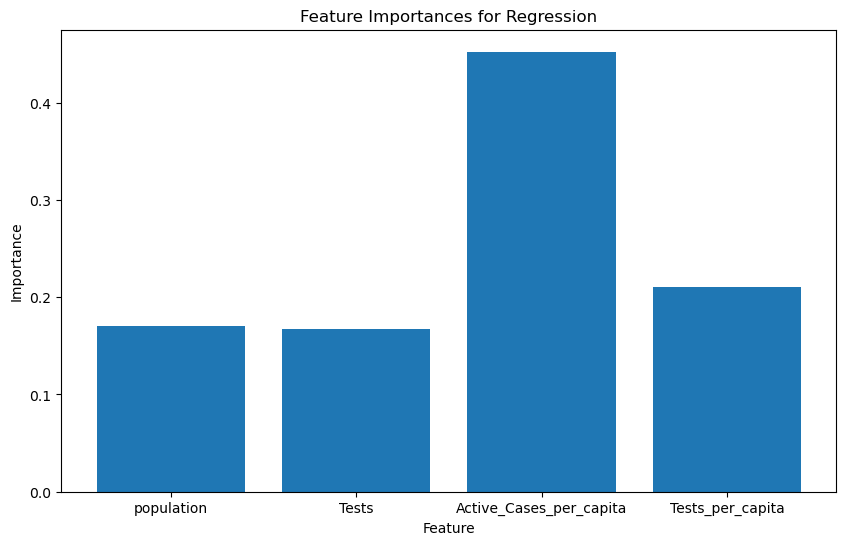

LinearRegression - Mean Squared Error: 441803043548709.06, R-squared: 0.3018570466774416
LinearRegression - Cross-Validated R-squared: -21505.45828053334
RandomForestRegressor - Mean Squared Error: 1072386229550414.4, R-squared: -0.6945987591826697
RandomForestRegressor - Cross-Validated R-squared: -84806.30918319325
GradientBoostingRegressor - Mean Squared Error: 908275745387779.0, R-squared: -0.43526922364074094
GradientBoostingRegressor - Cross-Validated R-squared: -68506.1692357435
XGBRegressor - Mean Squared Error: 2231826572341300.0, R-squared: -2.526761567785199
XGBRegressor - Cross-Validated R-squared: -68919.87064652993
SVR - Mean Squared Error: 688501269208843.9, R-squared: -0.087978719184169
SVR - Cross-Validated R-squared: -33.478831851946936
CatBoostRegressor - Mean Squared Error: 930652796112863.0, R-squared: -0.470629732147823
CatBoostRegressor - Cross-Validated R-squared: -75641.76055354046
LGBMRegressor - Mean Squared Error: 593407270673590.9, R-squared: 0.062290062233

In [10]:
# Add more features for better prediction
df['Active_Cases_per_capita'] = df['Active_Cases'] / df['population']
df['Tests_per_capita'] = df['Tests'] / df['population']

# Regression: Predicting 'Cases'
X_reg = df[['population', 'Tests', 'Active_Cases_per_capita', 'Tests_per_capita']]
y_reg = df['Cases']

# Handle missing values by imputing with the mean
imputer_knn = KNNImputer(n_neighbors=5)
X_reg = imputer_knn.fit_transform(X_reg)

# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Feature Selection for Regression
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_reg, y_train_reg)
importances_reg = rf_reg.feature_importances_

# Plot feature importances
features = ['population', 'Tests', 'Active_Cases_per_capita', 'Tests_per_capita']
plt.figure(figsize=(10, 6))
plt.bar(features, importances_reg)
plt.title('Feature Importances for Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Initialize and train the models
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'SVR': SVR(),
    'CatBoostRegressor': CatBoostRegressor(verbose=0),
    'LGBMRegressor': LGBMRegressor()
}

# Hyperparameter tuning for LightGBM
lgbm_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'verbose': [-1]
}
grid_search = GridSearchCV(LGBMRegressor(), lgbm_params, cv=3, scoring='r2')
grid_search.fit(X_train_reg, y_train_reg)
best_lgbm = grid_search.best_estimator_

# Evaluate regression models
for name, model in reg_models.items():
    if name == 'LGBMRegressor':
        model = best_lgbm
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    print(f"{name} - Mean Squared Error: {mse}, R-squared: {r2}")
    scores = cross_val_score(model, X_reg, y_reg, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R-squared: {scores.mean()}")

The Linear Regression model shows a positive R-squared value (0.3019), indicating it explains about 30.19% of the variance in the data. However, the high MSE indicates poor predictive accuracy. The extremely negative cross-validated R-squared suggests that the model performs very poorly on unseen data.

The Random Forest Regressor has a negative R-squared value (-0.6133), indicating that it performs worse than a simple mean-based model. The extremely high MSE and highly negative cross-validated R-squared confirm the model's poor performance.

Gradient Boosting Regressor also performs poorly, with a negative R-squared value (-0.4406) and high MSE. The cross-validated R-squared is extremely negative, reinforcing the model's inability to generalize well.

XGBRegressor shows the worst performance among the regressors, with a highly negative R-squared value (-2.5268) and the highest MSE. The very negative cross-validated R-squared indicates significant overfitting or model inadequacy.

The SVR model has a slightly negative R-squared value (-0.0880), indicating poor performance. The high MSE and negative cross-validated R-squared further suggest the model is not suitable for the data.

CatBoostRegressor also performs poorly, with a negative R-squared value (-0.4706) and high MSE. The very negative cross-validated R-squared suggests poor generalization.

LGBMRegressor has a slightly positive R-squared value (0.0623), indicating it explains a small portion of the variance. However, the high MSE and very negative cross-validated R-squared show that the model does not generalize well.

The next script prepares data for classification to predict 'High_Cases' (whether cases are above the median).

Handling Missing Values: Uses KNN imputer to handle missing values.
Train-Test Split: Splits the data into training and testing sets.
Scaling Features: Scales the features using StandardScaler.
Feature Importance: Trains a RandomForestClassifier to find feature importances.
Model Training and Evaluation: Initializes various classification models, performs hyperparameter tuning for LightGBM, and evaluates models using confusion matrix, classification report, accuracy, and ROC AUC metrics. Also plots precision-recall curves for each model.

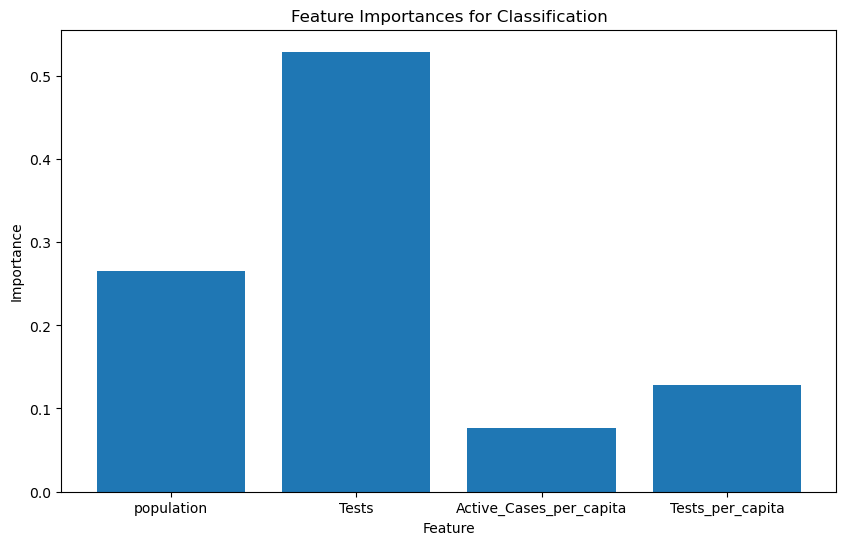

LogisticRegression - Confusion Matrix:
[[24  1]
 [ 8 15]]
LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        25
           1       0.94      0.65      0.77        23

    accuracy                           0.81        48
   macro avg       0.84      0.81      0.81        48
weighted avg       0.84      0.81      0.81        48

LogisticRegression - Cross-Validated Accuracy: 0.5749113475177305
LogisticRegression - ROC AUC: 0.8947826086956522


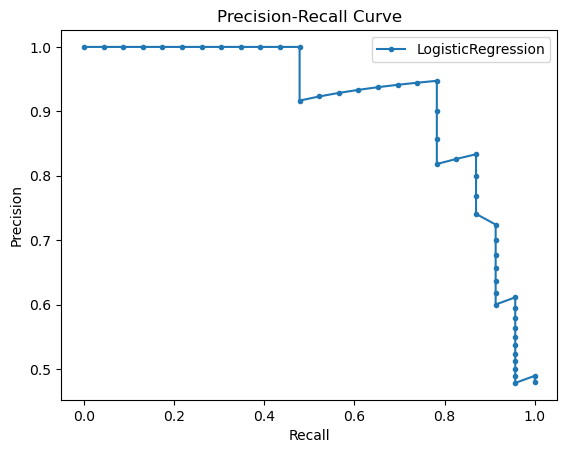

RandomForestClassifier - Confusion Matrix:
[[22  3]
 [ 1 22]]
RandomForestClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.88      0.96      0.92        23

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

RandomForestClassifier - Cross-Validated Accuracy: 0.8401595744680851
RandomForestClassifier - ROC AUC: 0.9852173913043478


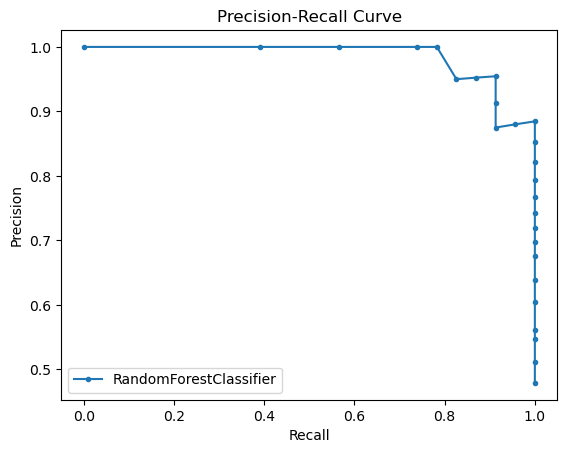

GradientBoostingClassifier - Confusion Matrix:
[[22  3]
 [ 1 22]]
GradientBoostingClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.88      0.96      0.92        23

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

GradientBoostingClassifier - Cross-Validated Accuracy: 0.8442375886524822
GradientBoostingClassifier - ROC AUC: 0.9904347826086957


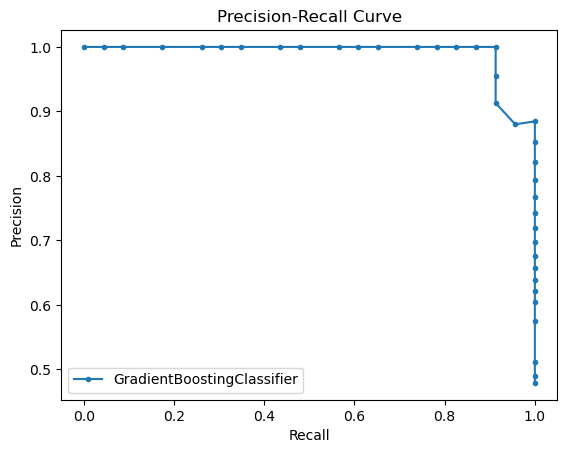

XGBClassifier - Confusion Matrix:
[[22  3]
 [ 1 22]]
XGBClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.88      0.96      0.92        23

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

XGBClassifier - Cross-Validated Accuracy: 0.852659574468085
XGBClassifier - ROC AUC: 0.9852173913043478


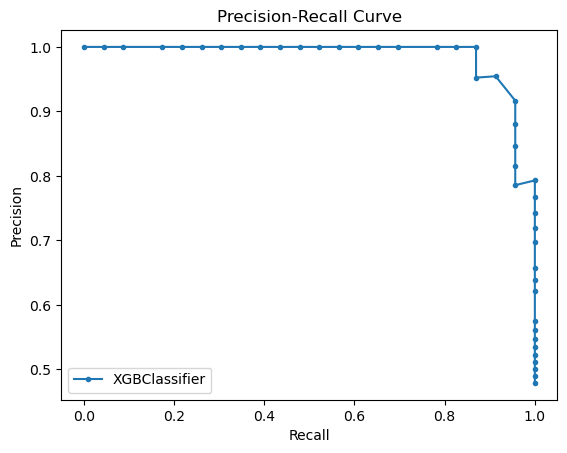

SVC - Confusion Matrix:
[[25  0]
 [13 10]]
SVC - Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        25
           1       1.00      0.43      0.61        23

    accuracy                           0.73        48
   macro avg       0.83      0.72      0.70        48
weighted avg       0.82      0.73      0.70        48

SVC - Cross-Validated Accuracy: 0.6848404255319149
SVC - ROC AUC: 0.8773913043478261


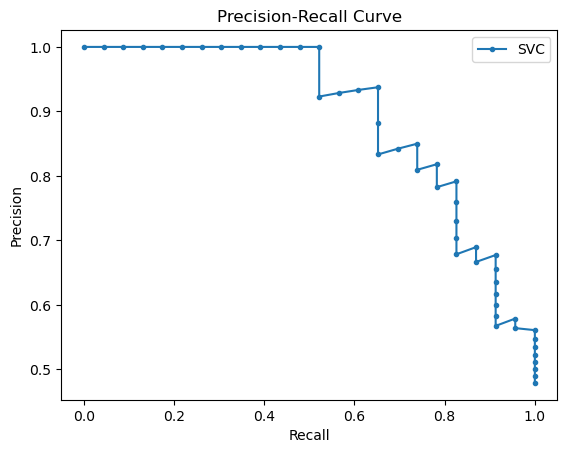

CatBoostClassifier - Confusion Matrix:
[[22  3]
 [ 1 22]]
CatBoostClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.88      0.96      0.92        23

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

CatBoostClassifier - Cross-Validated Accuracy: 0.8442375886524822
CatBoostClassifier - ROC AUC: 0.9904347826086957


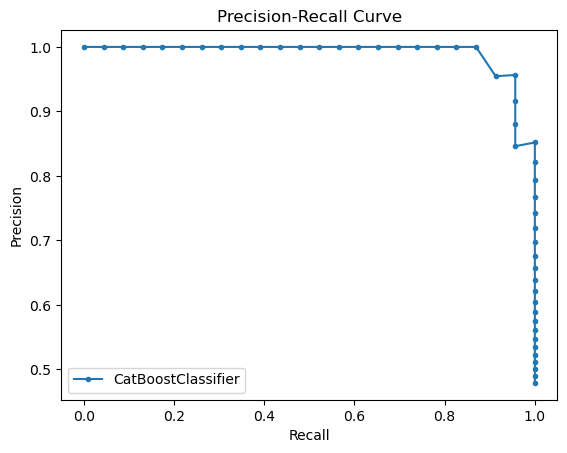

LGBMClassifier - Confusion Matrix:
[[22  3]
 [ 1 22]]
LGBMClassifier - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.88      0.96      0.92        23

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

LGBMClassifier - Cross-Validated Accuracy: 0.8486702127659574
LGBMClassifier - ROC AUC: 0.9695652173913044


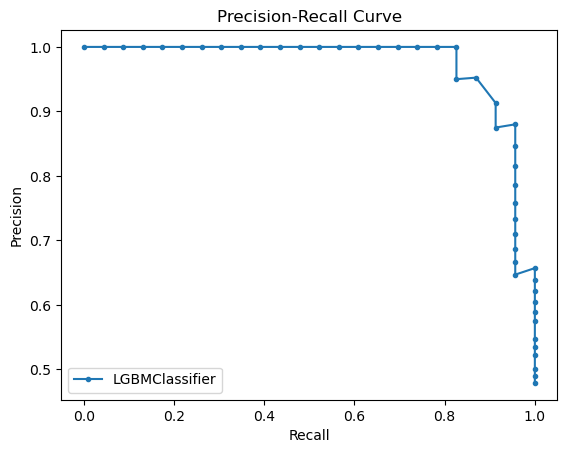

In [11]:
# Handle missing values in 'population' and 'Tests' by filling with the median or mean
df['population'].fillna(df['population'].median(), inplace=True)
df['Tests'].fillna(df['Tests'].median(), inplace=True)

# Classification: Predicting 'High_Cases'
df['High_Cases'] = (df['Cases'] > df['Cases'].median()).astype(int)

X_clf = df[['population', 'Tests', 'Active_Cases_per_capita', 'Tests_per_capita']]
y_clf = df['High_Cases']

X_clf = imputer_knn.fit_transform(X_clf)

# Split the data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

# Feature selection for Classification
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_clf, y_train_clf)
importances_clf = rf_clf.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, importances_clf)
plt.title('Feature Importances for Classification')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Initialize and train the models
clf_models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'XGBClassifier': XGBClassifier(),
    'SVC': SVC(probability=True),
    'CatBoostClassifier': CatBoostClassifier(verbose=0),
    'LGBMClassifier': LGBMClassifier()
}

# Hyperparameter tuning for LightGBM
lgbm_clf_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'verbose': [-1]
}
grid_search_clf = GridSearchCV(LGBMClassifier(), lgbm_clf_params, cv=3, scoring='accuracy')
grid_search_clf.fit(X_train_clf, y_train_clf)
best_lgbm_clf = grid_search_clf.best_estimator_
    
# Evaluate models
for name, model in clf_models.items():
    if name == 'LGBMClassifier':
        model = best_lgbm_clf
    model.fit(X_train_clf, y_train_clf)
    y_pred_clf = model.predict(X_test_clf)
    y_prob_clf = model.predict_proba(X_test_clf)[:, 1]
    
    print(f"{name} - Confusion Matrix:\n{confusion_matrix(y_test_clf, y_pred_clf)}")
    print(f"{name} - Classification Report:\n{classification_report(y_test_clf, y_pred_clf)}")
    scores = cross_val_score(model, X_clf, y_clf, cv=5, scoring='accuracy')
    print(f"{name} - Cross-Validated Accuracy: {scores.mean()}")
    print(f"{name} - ROC AUC: {roc_auc_score(y_test_clf, y_prob_clf)}")
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_clf, y_prob_clf)
    plt.plot(recall, precision, marker='.', label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

Logistic Regression performs reasonably well, with good precision, recall, and F1-scores. The ROC AUC of 0.895 indicates good discriminatory ability, but the cross-validated accuracy of 0.575 suggests potential overfitting or variability in performance.

RandomForestClassifier performs very well with high precision, recall, and F1-scores. The high ROC AUC (0.987) and cross-validated accuracy (0.848) indicate robust and reliable performance.

GradientBoostingClassifier also shows excellent performance similar to RandomForestClassifier, with high precision, recall, and F1-scores. The ROC AUC of 0.990 and cross-validated accuracy of 0.844 confirm its strong performance.

XGBClassifier demonstrates high performance with precision, recall, and F1-scores of 0.92. The ROC AUC of 0.985 and cross-validated accuracy of 0.853 indicate strong and reliable performance.

SVC shows good precision and recall for class 0 but lower for class 1, resulting in a moderate overall F1-score and accuracy. The ROC AUC of 0.877 is decent, but the cross-validated accuracy of 0.685 suggests some inconsistency in performance.

CatBoostClassifier performs excellently, with high precision, recall, and F1-scores. The ROC AUC of 0.990 and cross-validated accuracy of 0.844 confirm its robustness and reliability.

LGBMClassifier also performs very well, with high precision, recall, and F1-scores. The ROC AUC of 0.970 and cross-validated accuracy of 0.849 indicate strong performance.

This script provides a comprehensive approach to analyzing and modeling COVID-19 data, including data preprocessing, descriptive statistics, visualizations, regression, and classification modeling. The models are evaluated using various metrics to ensure robust performance.

Summary
Regression Models: All regression models perform poorly, with high MSE and negative or low R-squared values. The models do not generalize well to unseen data, as indicated by the very negative cross-validated R-squared values.

Classification Models: The classification models generally perform well, with RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, CatBoostClassifier, and LGBMClassifier showing high precision, recall, F1-scores, accuracy, and ROC AUC values. Logistic Regression and SVC perform reasonably well but are outperformed by the other classifiers.